In [1]:
%load_ext autoreload
%autoreload 2
# imports

import pacsltk.pacs_util as pacs_util
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

pacs_util.prepare_matplotlib_cycler()

# To avoid type 3 fonts: http://phyletica.org/matplotlib-fonts/
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import parse_util

import os
import glob
from datetime import timedelta

import pacsltk
print(pacsltk.__version__)

0.2.0


In [2]:
# Config paths
# EXP_CONFIG_NAME_DEFAULT = 'bench1_sleep_rand2_1000_200'
# EXP_CONFIG_NAME_DEFAULT = 'autoscale_go_500_10k_5'
# EXP_CONFIG_NAME_DEFAULT = 'autoscale_go_500_10k_5_rps'
EXP_CONFIG_NAME_DEFAULT = 'bench1_cpu_io_rps'
exp_config_name = os.getenv("EXP_CONFIG_NAME", EXP_CONFIG_NAME_DEFAULT)
exp_file = f"configs/{exp_config_name}.json"
overview_file_glob = f"results/{exp_config_name}/overview*.csv"
overview_file = glob.glob(overview_file_glob)[0]

print('config name:', exp_config_name)
print('overview file:', overview_file)
print('experiment file:', exp_file)

config name: bench1_cpu_io_rps
overview file: results/bench1_cpu_io_rps/overview_res-2021-03-20_09-46-14.csv
experiment file: configs/bench1_cpu_io_rps.json


In [3]:
# get overview
overview_df = pd.read_csv(overview_file, index_col=0, parse_dates=True)
overview_df.head(8)

,target,rps,res_name,request_func,workload_name,is_rps,exp_time_mins
0,1.0,1,res-2021-03-18_18-26-11,bench1_cpu_io_rps,bench1,True,60
1,1.0,2,res-2021-03-18_19-26-56,bench1_cpu_io_rps,bench1,True,60
2,1.0,3,res-2021-03-18_20-27-25,bench1_cpu_io_rps,bench1,True,60
3,1.0,5,res-2021-03-18_21-27-48,bench1_cpu_io_rps,bench1,True,60
4,1.0,7,res-2021-03-18_22-28-10,bench1_cpu_io_rps,bench1,True,60
5,1.0,10,res-2021-03-18_23-28-30,bench1_cpu_io_rps,bench1,True,60
6,1.0,15,res-2021-03-19_00-28-47,bench1_cpu_io_rps,bench1,True,60
7,1.0,20,res-2021-03-19_01-29-03,bench1_cpu_io_rps,bench1,True,60


In [4]:
batch_seconds = 600

# func used on each batch (part of a single experiment logs)
parse_cols_funcs = {
    'conc_window_average': lambda df: df['conc_window_average'].mean(),
    'average_ready_count': lambda df: df['ready_count'].mean(),
}

# func used on each batch (part of a single experiment logs)
parse_req_cols_funcs = {
    'client_elapsed_time': lambda df: df['client_elapsed_time'].mean(),
    'lambda_over_n': lambda df: df['lambda_over_n'].mean(),
}

parse_res = []
for res_name in tqdm(overview_df['res_name']):
    res_logger_file = f"results/{exp_config_name}/{res_name}_logger.csv"
    df = parse_util.parse_logger_file(res_logger_file)
    parse_cols_res = parse_util.parse_batch_custom_funcs(df, batch_seconds, parse_cols_funcs)
    
    res_reqs_file = f"results/{exp_config_name}/{res_name}_reqs.csv"
    df_req = parse_util.parse_reqs_file(res_reqs_file)
    parse_req_res = parse_util.parse_batch_custom_funcs(df_req, batch_seconds, parse_req_cols_funcs)

    parse_cols_res.update(parse_req_res)

    parse_res.append(parse_cols_res)

parse_res_df = pd.DataFrame(data=parse_res)
parse_res_df.head()

  0%|          | 0/40 [00:00<?, ?it/s]

,conc_window_average_mean,conc_window_average_var,conc_window_average_se,conc_window_average_ci,average_ready_count_mean,average_ready_count_var,average_ready_count_se,average_ready_count_ci,client_elapsed_time_mean,client_elapsed_time_var,client_elapsed_time_se,client_elapsed_time_ci,lambda_over_n_mean,lambda_over_n_var,lambda_over_n_se,lambda_over_n_ci
0,0.092804,0.000047,0.003058,0.005993,1.993349,0.000904,0.013450,0.026361,0.174884,0.000022,0.002091,0.004099,0.506352,0.000155,0.005576,0.010929
1,0.135685,0.000073,0.003808,0.007464,3.122339,0.001907,0.019529,0.038276,0.211781,0.000298,0.007722,0.015136,0.646860,0.000047,0.003054,0.005986
2,0.140022,0.000049,0.003132,0.006138,4.795579,0.008884,0.042153,0.082620,0.212974,0.000068,0.003699,0.007249,0.632386,0.000193,0.006208,0.012167
3,0.135473,0.000026,0.002299,0.004507,7.522682,0.016150,0.056833,0.111393,0.205661,0.000016,0.001771,0.003471,0.668272,0.000131,0.005115,0.010025
4,0.135197,0.000021,0.002031,0.003981,10.401064,0.011073,0.047059,0.092237,0.201578,0.000002,0.000691,0.001355,0.675176,0.000043,0.002919,0.005722


In [5]:
orig_overview_parsed_df = pd.concat([overview_df, parse_res_df], axis=1)
orig_overview_parsed_df.head()

,target,rps,res_name,request_func,workload_name,is_rps,exp_time_mins,conc_window_average_mean,conc_window_average_var,conc_window_average_se,...,average_ready_count_se,average_ready_count_ci,client_elapsed_time_mean,client_elapsed_time_var,client_elapsed_time_se,client_elapsed_time_ci,lambda_over_n_mean,lambda_over_n_var,lambda_over_n_se,lambda_over_n_ci
0,1.0,1,res-2021-03-18_18-26-11,bench1_cpu_io_rps,bench1,True,60,0.092804,0.000047,0.003058,...,0.013450,0.026361,0.174884,0.000022,0.002091,0.004099,0.506352,0.000155,0.005576,0.010929
1,1.0,2,res-2021-03-18_19-26-56,bench1_cpu_io_rps,bench1,True,60,0.135685,0.000073,0.003808,...,0.019529,0.038276,0.211781,0.000298,0.007722,0.015136,0.646860,0.000047,0.003054,0.005986
2,1.0,3,res-2021-03-18_20-27-25,bench1_cpu_io_rps,bench1,True,60,0.140022,0.000049,0.003132,...,0.042153,0.082620,0.212974,0.000068,0.003699,0.007249,0.632386,0.000193,0.006208,0.012167
3,1.0,5,res-2021-03-18_21-27-48,bench1_cpu_io_rps,bench1,True,60,0.135473,0.000026,0.002299,...,0.056833,0.111393,0.205661,0.000016,0.001771,0.003471,0.668272,0.000131,0.005115,0.010025
4,1.0,7,res-2021-03-18_22-28-10,bench1_cpu_io_rps,bench1,True,60,0.135197,0.000021,0.002031,...,0.047059,0.092237,0.201578,0.000002,0.000691,0.001355,0.675176,0.000043,0.002919,0.005722


# Make Workload Plots

In [6]:
# list all available columns
orig_overview_parsed_df.columns

Index(['target', 'rps', 'res_name', 'request_func', 'workload_name', 'is_rps',
       'exp_time_mins', 'conc_window_average_mean', 'conc_window_average_var',
       'conc_window_average_se', 'conc_window_average_ci',
       'average_ready_count_mean', 'average_ready_count_var',
       'average_ready_count_se', 'average_ready_count_ci',
       'client_elapsed_time_mean', 'client_elapsed_time_var',
       'client_elapsed_time_se', 'client_elapsed_time_ci',
       'lambda_over_n_mean', 'lambda_over_n_var', 'lambda_over_n_se',
       'lambda_over_n_ci'],
      dtype='object')

In [7]:
# filter for some values
# plot_targets = [1,2,5,10]
plot_targets = [1,1.5,2,2.5,3,5,10]
overview_parsed_df = orig_overview_parsed_df[orig_overview_parsed_df['target'].isin(plot_targets)]
overview_parsed_df.head()

,target,rps,res_name,request_func,workload_name,is_rps,exp_time_mins,conc_window_average_mean,conc_window_average_var,conc_window_average_se,...,average_ready_count_se,average_ready_count_ci,client_elapsed_time_mean,client_elapsed_time_var,client_elapsed_time_se,client_elapsed_time_ci,lambda_over_n_mean,lambda_over_n_var,lambda_over_n_se,lambda_over_n_ci
0,1.0,1,res-2021-03-18_18-26-11,bench1_cpu_io_rps,bench1,True,60,0.092804,0.000047,0.003058,...,0.013450,0.026361,0.174884,0.000022,0.002091,0.004099,0.506352,0.000155,0.005576,0.010929
1,1.0,2,res-2021-03-18_19-26-56,bench1_cpu_io_rps,bench1,True,60,0.135685,0.000073,0.003808,...,0.019529,0.038276,0.211781,0.000298,0.007722,0.015136,0.646860,0.000047,0.003054,0.005986
2,1.0,3,res-2021-03-18_20-27-25,bench1_cpu_io_rps,bench1,True,60,0.140022,0.000049,0.003132,...,0.042153,0.082620,0.212974,0.000068,0.003699,0.007249,0.632386,0.000193,0.006208,0.012167
3,1.0,5,res-2021-03-18_21-27-48,bench1_cpu_io_rps,bench1,True,60,0.135473,0.000026,0.002299,...,0.056833,0.111393,0.205661,0.000016,0.001771,0.003471,0.668272,0.000131,0.005115,0.010025
4,1.0,7,res-2021-03-18_22-28-10,bench1_cpu_io_rps,bench1,True,60,0.135197,0.000021,0.002031,...,0.047059,0.092237,0.201578,0.000002,0.000691,0.001355,0.675176,0.000043,0.002919,0.005722


In [8]:
rps_ticks = overview_parsed_df['rps'].unique()

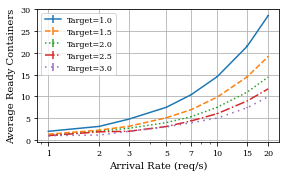

In [9]:
plt.figure(figsize=(4,2.5))
for target_value in overview_parsed_df['target'].unique():
    sub_df = overview_parsed_df.loc[overview_parsed_df['target'] == target_value, :]
    # plt.semilogx(sub_df['rps'], sub_df['average_ready_count_mean'])
    plt.errorbar(sub_df['rps'], sub_df['average_ready_count_mean'], yerr=sub_df['average_ready_count_ci'], label=f"Target={target_value}")

plt.gca().set_xscale('log')
plt.xticks(rps_ticks, rps_ticks)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.xlabel("Arrival Rate (req/s)")
plt.ylabel("Average Ready Containers")
plt.gcf().subplots_adjust(left=0.13, bottom=0.20)
parse_util.tmp_fig_save('01_average_ready_containers_vs_arrival_rate', exp_config_name)

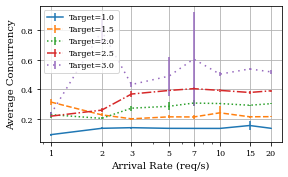

In [10]:
plt.figure(figsize=(4,2.5))
for target_value in overview_parsed_df['target'].unique():
    sub_df = overview_parsed_df.loc[overview_parsed_df['target'] == target_value, :]
    # plt.semilogx(sub_df['rps'], sub_df['conc_window_average_mean'])
    plt.errorbar(sub_df['rps'], sub_df['conc_window_average_mean'], yerr=sub_df['conc_window_average_ci'], label=f"Target={target_value}")

plt.gca().set_xscale('log')
plt.xticks(rps_ticks, rps_ticks)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.xlabel("Arrival Rate (req/s)")
plt.ylabel("Average Concurrency")
plt.gcf().subplots_adjust(left=0.13, bottom=0.20)
parse_util.tmp_fig_save('02_conc_window_average_vs_arrival_rate', exp_config_name)

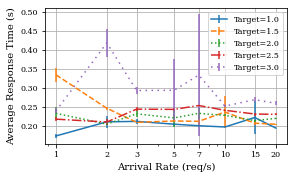

In [11]:
plt.figure(figsize=(4,2.5))
for target_value in overview_parsed_df['target'].unique():
    sub_df = overview_parsed_df.loc[overview_parsed_df['target'] == target_value, :]
    # plt.semilogx(sub_df['rps'], sub_df['conc_window_average_mean'])
    plt.errorbar(sub_df['rps'], sub_df['client_elapsed_time_mean'], yerr=sub_df['client_elapsed_time_ci'], label=f"Target={target_value}")

plt.gca().set_xscale('log')
plt.xticks(rps_ticks, rps_ticks)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.xlabel("Arrival Rate (req/s)")
plt.ylabel("Average Response Time (s)")
plt.gcf().subplots_adjust(left=0.13, bottom=0.20)
parse_util.tmp_fig_save('03_average_resp_time_vs_arrival_rate', exp_config_name)

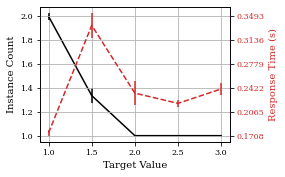

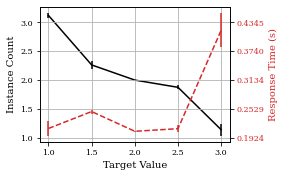

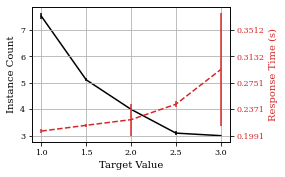

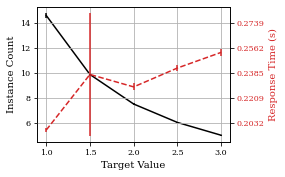

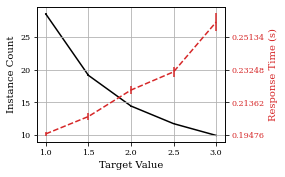

In [12]:
# let's see if we can make plots for effect of CC
from matplotlib import ticker

for plot_arrival_rate in [1,2,5,10,20]:
    sub_overview_df = orig_overview_parsed_df[orig_overview_parsed_df['rps'] == plot_arrival_rate]

    plt.figure(figsize=(4,2.5))
    color = 'k'
    ax1 = plt.gca()
    ax1.errorbar(sub_overview_df['target'], sub_overview_df['average_ready_count_mean'], yerr=sub_overview_df['average_ready_count_ci'], color=color)
    ax1.set_xlabel('Target Value')
    ax1.set_ylabel('Instance Count', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    plt.grid(True, axis='x')

    color = 'tab:red'
    ax2 = plt.gca().twinx()
    ax2.errorbar(sub_overview_df['target'], sub_overview_df['client_elapsed_time_mean'], yerr=sub_overview_df['client_elapsed_time_ci'], ls='--', color=color)
    ax2.set_ylabel('Response Time (s)', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.grid(None)
    # ax2.set_ylim([0.4,0.6])

    # aligning ticks for grids
    l = ax1.get_ylim()
    l2 = ax2.get_ylim()
    f = lambda x : l2[0]+(x-l[0])/(l[1]-l[0])*(l2[1]-l2[0])
    ticks = f(ax1.get_yticks())
    ax2.yaxis.set_major_locator(ticker.FixedLocator(ticks))

    # final config
    plt.gcf().subplots_adjust(left=0.13, bottom=0.20)
    plt.tight_layout()

    parse_util.tmp_fig_save(f'04_inst_count_resp_time_target_arrival_{plot_arrival_rate}', exp_config_name)